## Feature Development Extraction: Neurophysiology [dyskinesia project]




<b> Content </b>


<b> Aperiodic estimates </b>
Relevant literature:
- Periodic and a-periodic components relevance and interaction, different reasons (per + a-per) for signal changes observed within a specific bandwidth. Aperiodic component (complicated) vs exponent (1/f) (Donoghue, ..., Shestyuk & Voytek, Nature Neurosc 2020 : https://www.nature.com/articles/s41593-020-00744-x)
- cycle-by-cycle features: bycycle toolbox (Cole & Voytek, J of Neurophys 2019, https://journals.physiology.org/doi/full/10.1152/jn.00273.2019)
- aperiodic component, PD severity, and cortico-subcortico-activity, Bush & Zou, Richardson, bioRxiv 2023 https://www.biorxiv.org/content/10.1101/2023.02.08.527719v1?rss=1

<b> Periodic component analysis: </b> 
- Try Wavelet Dceomposition vs Welch (tapered) Spectral Decomposition





### 0. Loading packages and functions, defining paths



In [1]:
# Importing Python and external packages
import os
import sys
import importlib
import json
import csv
from dataclasses import dataclass, field, fields
from collections import namedtuple
from typing import Any
from itertools import compress
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn as sk
from scipy.stats import pearsonr, mannwhitneyu

import matplotlib.pyplot as plt

from scipy import signal, stats
from array import array
import datetime as dt
# #mne
# import mne_bids
import mne


In [2]:
# check some package versions for documentation and reproducability
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
# print('mne_bids', mne_bids.__version__)
# print('mne', mne.__version__)
# print('sci-py', scipy.__version__)
print('sci-kit learn', sk.__version__)
## FEB 2022:
# Python sys 3.9.7 (default, Sep 16 2021, 08:50:36) 
# [Clang 10.0.0 ]
# pandas 1.3.4
# numpy 1.20.3
# mne_bids 0.9
# mne 0.24.1
# sci-py 1.7.1
# sci-kit learn 1.0.1

Python sys 3.9.0 (default, Nov 15 2020, 08:30:55) [MSC v.1916 64 bit (AMD64)]
pandas 1.4.4
numpy 1.23.3
sci-kit learn 1.1.3


In [3]:
def get_project_path_in_notebook(
    subfolder: str = '',
):
    """
    Finds path of projectfolder from Notebook.
    Start running this once to correctly find
    other modules/functions
    """
    path = os.getcwd()

    while path[-20:] != 'dyskinesia_neurophys':

        path = os.path.dirname(path)
    
    return path

In [4]:
# define local storage directories
projectpath = get_project_path_in_notebook()
codepath = os.path.join(projectpath, 'code')
figpath = os.path.join(projectpath, 'figures')
datapath = os.path.join(projectpath, 'data')

In [5]:
os.chdir(codepath)
# own utility functions
import utils.utils_fileManagement as utilsFiles
import utils.utils_windowing as utilsWindows
# own data preprocessing functions
import lfpecog_preproc.preproc_data_management as dataMng
import lfpecog_preproc.preproc_filters as fltrs
# own data exploration functions
import lfpecog_features.feats_read_proc_data as read_data
import lfpecog_plotting.expl_plotting as expl_plot
import lfpecog_features.feats_spectral_baseline as specBase
import lfpecog_features.feats_spectral_features as spectral
import lfpecog_features.feats_spectral_helpers as specHelp


import lfpecog_preproc.preproc_import_scores_annotations as importClin
import lfpecog_analysis.import_ephys_results as importResults
import lfpecog_analysis.get_acc_derivs as accDerivs


from lfpecog_plotting.plotHelpers import remove_duplicate_legend

### 1. Load Merged Sub-Data

In [6]:
os.chdir(codepath)

from utils.utils_fileManagement import (get_project_path,
                                        load_class_pickle,
                                        save_class_pickle,
                                        mergedData,
                                        correct_acc_class)


#### load none ephys pickle

In [206]:
subs_to_plot = [
    '008', '009', '010', '012', 
    '013', '014', '016']

data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    acc = load_class_pickle(os.path.join(
        get_project_path('data'),
        'merged_sub_data', data_version,
        f'{sub}_mergedDataClass_{data_version}_noEphys.P'
    ))
    acc = correct_acc_class(acc)

    mins_recording.append(acc.data.shape[0] / acc.fs / 60)

#### load ephys pickle

WINDOWED DATA

In [7]:
subs_to_plot = [
    # '008', '009', '010', '012', 
    # '013', '014',
    '012',
]
task = 'rest'
data_version = 'v3.1'
mins_recording = []

for sub in subs_to_plot:
    # load Acc-detected movement labels
    data = load_class_pickle(os.path.join(
        get_project_path('data'), 'windowed_data_classes_60s',
        data_version, f'sub-{sub}', task,
        f'{sub}_mneEpochs_{task}_{data_version}_win60s_overlap0.5.P'
    ))
    # acc = correct_acc_class(acc)


In [8]:
data.list_mne_objects[0].times.shape

data.list_mne_objects[0].ch_names

data.list_mne_objects[0].get_data().shape

(112, 32, 1024)

MERGED DATA per DATATYPE (source)


In [113]:
subs_incl = [
    '013', 
    # '009', '010', '012', 
    # '013', '014',
    # '012',
]
# task = 'rest'
data_version = 'v3.0'

for sub in subs_incl:
    # load Acc-detected movement labels
    data = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        data_version,
        f'{sub}_mergedDataClass_{data_version}.P'
    ))

In [157]:
sub = '012'
dat = {}
dType = 'lfp_left'
dat[dType] = load_class_pickle(os.path.join(
        get_project_path('data'), 'merged_sub_data',
        data_version, f'sub-{sub}',
        f'{sub}_mergedData_{data_version}_{dType}.P'
    ))

In [161]:
print(vars(dat['lfp_left']).keys())

print(dat['lfp_left'].colnames)

dict_keys(['sub', 'data_version', 'data', 'colnames', 'times', 'fs'])
['dopa_time', 'LFP_L_02_03', 'LFP_L_03_04', 'LFP_L_04_02', 'LFP_L_02_05', 'LFP_L_03_06', 'LFP_L_04_07', 'LFP_L_05_06', 'LFP_L_06_07', 'LFP_L_07_05', 'LFP_L_05_08', 'LFP_L_06_08', 'LFP_L_07_08', 'task', 'left_tap', 'right_tap', 'left_move', 'right_move', 'no_move']


In [160]:
# col = 'LFP_L_03_04'
# i_col = np.where([c == col for c in dat[dType].colnames])[0][0]
# plt.plot(
#     dat[dType].times,
#     dat[dType].data[:, i_col]
# )
# plt.show()
# col = 'task'
# i_col = np.where([c == col for c in dat[dType].colnames])[0][0]
# plt.plot(
#     dat[dType].times,
#     dat[dType].data[:, i_col]
# )
# plt.show()

#### fooof for spectral features

for now decided to use knee-models

´fm_knee = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee', # fixed or knee
    verbose=False,
)`

fm_knee.fit(f, pxx, [4, 148])

params:
- fm_knee.get_results().error  # error of the fit
- fm_knee.get_results().r_squared  # r^2 (goodness) of fit
- fm_knee.get_results().aperiodic_params  # offset, knee, exponent OR offset, exponent
- fm_knee.get_results().peak_params  # 2d array with pro row one peak's [mid-f, power, bandwidth]
- fm_knee.get_results().gaussian_params  # 2d array with Gaussian fits of peaks [mid-f, height, sd]


In [22]:
from fooof import FOOOF


fooof_ft_path = os.path.join(
    get_project_path('results'),
    'features',
    'psds',
    'fooofed_psds',
    f'{data_version}_60sWin_50overlap',
    'fooof_per_10sec'
)
if not os.path.exists(fooof_ft_path): os.makedirs(fooof_ft_path)

fooof_fig_dir = os.path.join(fooof_ft_path, 'plot_checks')

In [63]:

fs = data.info['sfreq']
nperseg = 1024
fooof_range = [4, 98]  # wider window -> more accurate, more comp-time
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'midgamma': [60, 90]}


In [11]:
# importlib.reload(specHelp)
# importlib.reload(spectral)

# save_csv = True
# plot_examples = False

# n_epochs2merge = 10 / .5  # desired epoch length / current epoch length


# for i_win in np.arange(len(data.list_mne_objects))[4:]:
#     # get spectral power value per window (60-sec)
#     win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
#     chnames = data.list_mne_objects[i_win].ch_names

#     epoch_feats, epoch_feats_lists = {}, {}
#     fits = {}

#     for i_ep in np.arange(0, win_dat.shape[0], int(n_epochs2merge)):
#         # merge epochs
#         tempdat = win_dat[i_ep, :, :]
#         for i2 in np.arange(i_ep + 1, i_ep + n_epochs2merge):
#             try:
#                 tempdat = np.concatenate((tempdat, win_dat[i2, :, :]), axis=1)
#             except IndexError:  # exceeds end of array bcs of blind + 20
#                 pass

#         (
#             epoch_feats[i_ep],
#             epoch_feats_lists[i_ep],
#             fits[i_ep]
#         ) = spectral.get_fooof_fts_per_epoch(
#             epoch_dat=tempdat,
#             ch_names=chnames,
#             fs=fs,
#             nperseg=nperseg,
#             max_n_fooof_peaks=8,
#             fooof_range=fooof_range,
#             i_e=i_ep, fooof_fig_dir=fooof_fig_dir,
#             plot_examples=plot_examples,
#         )

#     all_fits = []
#     for i in fits.keys(): all_fits.extend(fits[i])
        
#     print(f'WIN {i_win}, ALL epochs: mean R2 {round(np.mean(all_fits), 2)} +/- {round(np.std(all_fits), 2)}')

#     fname = f'fooofPowers_{sub}_{task}_win{i_win}.csv'

#     winfeats = spectral.create_windowFrame_specFeats(
#         epoch_feats, save_csv=save_csv,
#         csv_path=fooof_ft_path, csv_fname=fname,
#         fooof_fits=fits,
#     )


In [3]:
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='knee',
    verbose=False,
    max_n_peaks=5,
)

win_dat = data.list_mne_objects[i_win].get_data()
f, pxx = signal.welch(win_dat[5, 2, :], fs=fs, nperseg=nperseg,)
pxx = specHelp.correct_notch_throughs(f, pxx, np.arange(50, 1201, 50))

fm.report(f, pxx, [4, 98])


#### test SSD with meet toolbox

In [9]:
import meet.meet as meet

In [42]:
# get data
i_win = 5
win_dat = data.list_mne_objects[i_win].get_data()  # epochs x channels x times
ch_names = data.list_mne_objects[i_win].ch_names
fs = data.info['sfreq']
nperseg = 1024
bw_ranges = {   'alpha': [8, 12],
                'lo_beta': [12, 20],
                'hi_beta': [20, 35],
                'beta': [12, 35],
                'midgamma': [60, 90]}


In [78]:
from lfpecog_features import feats_SSD as ssd

In [111]:
# test and plot SSD functionality

importlib.reload(ssd)

SOURCE_SEL = 'ECOG'
F_BAND_SEL = 'midgamma'
epoch_i = 50
plt.close()
# select 2d data of one source (n-channels x n-samples)
ch_sel = [n.startswith(SOURCE_SEL) for n in ch_names]
epoch_dat = win_dat[epoch_i, ch_sel, :]

fig, axes = plt.subplots(2, 1, figsize=(8,8))

for F_BAND_SEL in ['lo_beta', 'hi_beta', 'beta', 'midgamma']:
    ssd_filt_data, ssd_pattern, ssd_eigvals = ssd.get_SSD_component(
        data_2d=epoch_dat,
        fband_interest=bw_ranges[F_BAND_SEL],
        s_rate=fs,
        use_freqBand_filtered=True,
        return_comp_n=0,
    )
    f, psd = signal.welch(ssd_filt_data, axis=-1, nperseg=fs, fs=fs)

    axes[0].plot(ssd_filt_data, label=F_BAND_SEL)
    axes[1].plot(f, psd, label=F_BAND_SEL)

# psd of origin
for i in range(epoch_dat.shape[0]):
    f, psd = signal.welch(epoch_dat[i, :], nperseg=fs, fs=fs)
    axes[2].plot(f, psd, label=F_BAND_SEL, c='k', alpha=.3,)
axes[2].set_xlim(0, 100)


axes[0].legend(ncol=4)
axes[1].legend()
axes[0].set_title('SSD filtered bands')
axes[1].set_title('PSD (after SSD)')
axes[1].set_xlim(0, 100)

plt.close()



(1024,)


In [39]:
# # plot SSD Components
# for i, b in enumerate(SSD_beta):
#     plt.plot(b, label=f'ch {i}',
#              alpha=(1 - (i * .2)),
#              lw=5 - i)
# # beta1d = SSD_beta.T @ np.atleast_2d(SSD_eigvals).T  # combined signal, not relevant
# # plt.plot(beta1d, label='product', c='k')
# plt.legend()
# plt.show()

In [56]:
import matplotlib as mpl


In [90]:

ch = 'ECOG_R_05_06'
i_ch = np.where([name == ch for name in data.list_mne_objects[0].ch_names])[0][0]
ch_wins = data.list_mne_objects[0].get_data()[:, 0, :]
fs = data.info['sfreq']
nperseg = 1024

In [240]:
chs_incl = np.arange(1, 6)

for n, i_ch in enumerate(chs_incl):
    temp = data.list_mne_objects[0].get_data()[:20:2, i_ch, :].ravel()
    temp = temp.reshape(1, len(temp))

    if n == 0: multi_arr = temp
    else:
        multi_arr = np.concatenate([multi_arr, temp], axis=0)    
multi_arr.shape

(5, 10240)

In [309]:

ch = 'ECOG_R_05_06'
i_ch = np.where([name == ch for name in data.list_mne_objects[0].ch_names])[0][0]
ch_wins = data.list_mne_objects[0].get_data()[:, 0, :]
fs = data.info['sfreq']
nperseg = 1024

fig, axes = plt.subplots(1, 3, figsize=(12, 6))
x_see = (5, 98)

xlabels = [1, 5, 10, 25, 50, 75, 95, 200, 400]

for i_win in np.arange(0, 50):

    f, Px = signal.welch(
        ch_wins[i_win, :], fs=fs, nperseg=nperseg,
    )
    f[0] = 1
    # Px = Px[1:]
    axes[0].plot(
        f, Px,
        alpha=.2, color='k',)
    axes[0].set_xlabel('Freq (Hz)')
    axes[0].set_ylabel('Power')
    axes[0].set_xticks(xlabels)
    axes[0].set_xticklabels(xlabels)
    axes[0].set_xlim(x_see)

    axes[1].plot(
        f, np.log(Px),
        alpha=.2, color='k',)
    axes[1].set_xticks(xlabels)
    axes[1].set_xticklabels(xlabels)
    axes[1].set_xlabel('Freq (Hz)')
    axes[1].set_ylabel('Log-Power')
    axes[1].set_xlim(x_see)

    axes[2].plot(
        np.log(f), np.log(Px),
        alpha=.2, color='k',)
    axes[2].set_xticks(np.log(xlabels))
    axes[2].set_xticklabels(xlabels)
    axes[2].set_xlabel('Log-Freq (Hz)')
    axes[2].set_ylabel('Log-Power')
    axes[2].set_xlim(np.log(x_see))

# add mean
f_mean, Px_mean = signal.welch(
    ch_wins[:, :], fs=fs, nperseg=nperseg,
    axis=1,)
f_mean[0] = 1
Px_mean = np.mean(Px_mean, axis=0)

axes[0].plot(
        f_mean, Px_mean,
        alpha=.4, color='orange', lw=5,)
axes[1].plot(
        f_mean, np.log(Px_mean),
        alpha=.4, color='orange', lw=5,)
axes[2].plot(
        np.log(f_mean), np.log(Px_mean),
        alpha=.4, color='orange', lw=5,)


plt.close()

SSD on 2D arrays to get info about spatial patterns

In [241]:
# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=multi_arr, fs=fs,
    freqband_to_optim=(14, 18)
)

# spec_ratio, sorter = ssd_obj.get_spectral_ratio(ssd_sources)

Setting up band-pass filter from 14 - 18 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 18.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 18.50 Hz)
- Filter length: 6759 samples (3.300 sec)

Setting up band-pass filter from 10 - 22 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 9.50 Hz)
- Upper passband edge: 22.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 22.50 Hz

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
c:\Users\habetsj\Research\projects\dyskinesia_neurophys\co

LinAlgError: The leading minor of order 3 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

Setting up band-pass filter from 16 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 16.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 15.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 20.50 Hz)
- Filter length: 6759 samples (3.300 sec)

Setting up band-pass filter from 12 - 24 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 11.50 Hz)
- Upper passband edge: 24.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 24.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


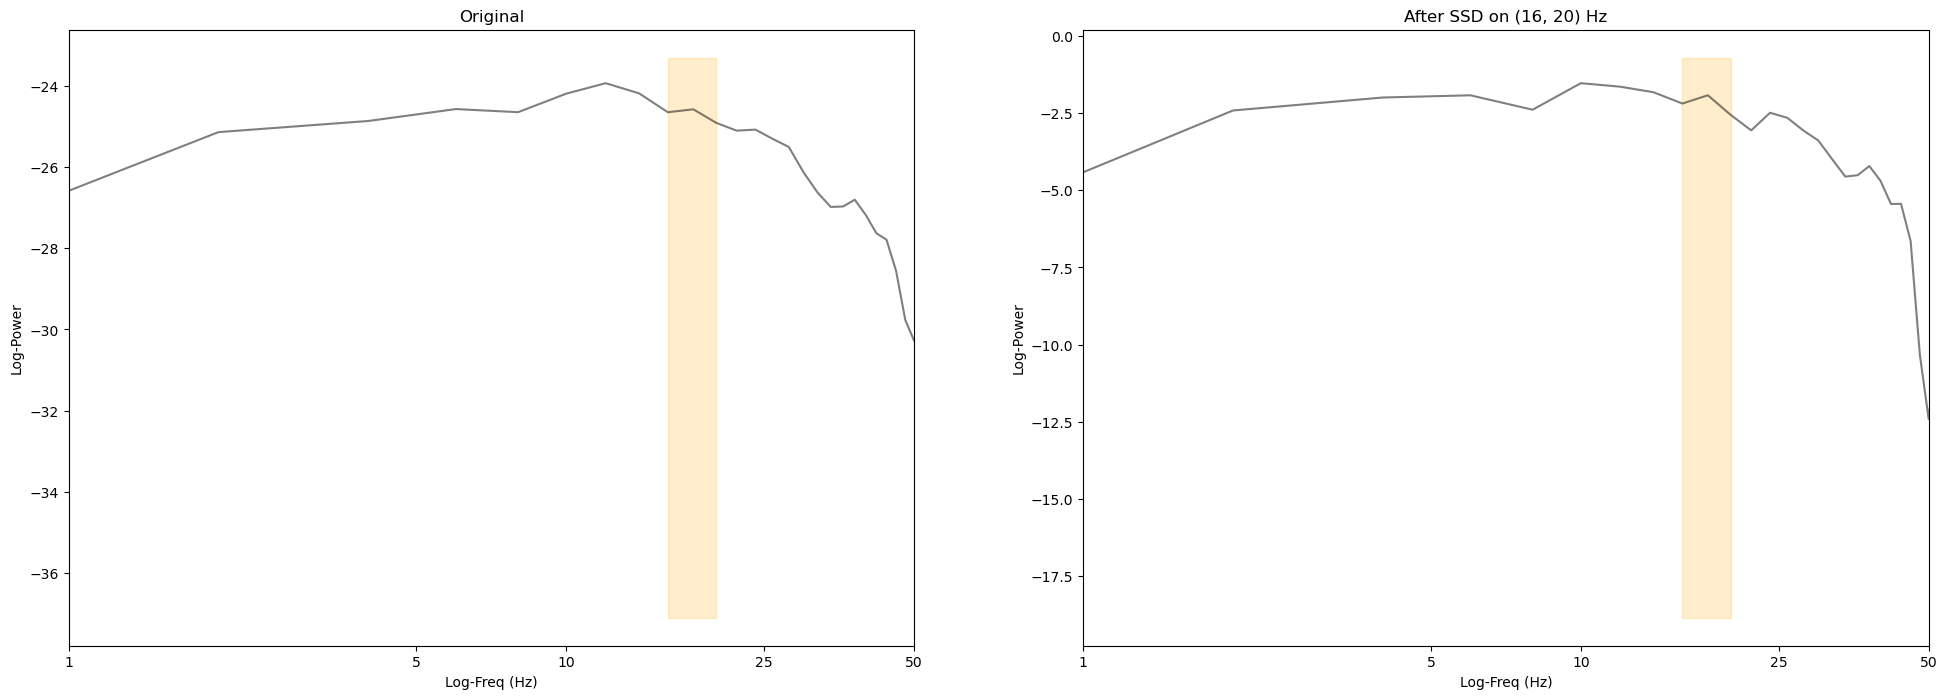

In [188]:
importlib.reload(specHelp)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

xlabels = [1, 5, 10, 25, 50, 75, 100, 200, 400]

freqs_ssd = (16, 20)
longsig = np.ravel(ch_wins[:20:2, :])
sig = np.ravel(ch_wins[18:20, :])

ssd_sig = longsig

f, Px = signal.welch(
    ssd_sig, fs=fs, nperseg=nperseg,
)
f[0] = 1
axes[0].plot(
        np.log(f), np.log(Px),
        alpha=.5, color='k',)
axes[0].set_xticks(np.log(xlabels))
axes[0].set_xticklabels(xlabels)
axes[0].set_xlabel('Log-Freq (Hz)')
axes[0].set_ylabel('Log-Power')
axes[0].set_xlim(0, np.log(50))

axes[0].set_title('Original')

# Perform SSD # 1
ssd_obj, ssd_sources = specHelp.SSD_on_array(
    array=ssd_sig, fs=fs,
    freqband_to_optim=freqs_ssd
)
print(ssd_sources.shape)
psd, freqs = mne.time_frequency.psd_array_welch(
    ssd_sources, sfreq=fs, n_fft=1024)

freqs[0] = 1
axes[1].plot(
    np.log(freqs), np.log(np.ravel(psd)),
    alpha=.5, color='k',)
axes[1].set_xticks(np.log(xlabels))
axes[1].set_xticklabels(xlabels)
axes[1].set_xlabel('Log-Freq (Hz)')
axes[1].set_ylabel('Log-Power')
axes[1].set_xlim(0, np.log(50))

for ax in axes:
    ax.fill_betweenx(
        y=ax.get_ylim(),
        x1=np.log(freqs_ssd[0]), x2=np.log(freqs_ssd[1]),
        color='orange', alpha=.2,)
axes[1].set_title(f'After SSD on {freqs_ssd} Hz')

plt.show()

## SPECTRAL features

get fooof running


selected ecog-channel: ECOG_L_1
selected stn-channel: LFP_L_0_1
Total time UP + DOWN: 0.62 sec
Peak frequencies:
Beta ([13, 30] Hz) peak: 17.5 Hz
Gamma ([60, 90]) peak: 85.8 Hz
Local peak heights:
Beta: 2.0678798673600234,
Gamma: 2.6860669038169434


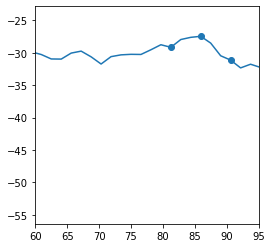

In [ ]:
from fooof import FOOOF
fm = FOOOF()

# FOOOF peak definition -> MODULE
beta_range = [13, 30]
gamma_range = [60, 90]
fm = FOOOF(
    peak_width_limits=(.5, 5),
    peak_threshold=.5,
    aperiodic_mode='fixed',
    verbose=False,
)
f_range = [3, 90]
fm.fit(fx, psd, f_range)
beta_f, beta_P, beta_w = get_band_peak_fm(fm, beta_range, select_highest=True)
gamma_f, gamma_P, gamma_w = get_band_peak_fm(fm, gamma_range, select_highest=True)
print(f'Peak frequencies:\nBeta ({beta_range} Hz) peak: '
    f'{np.round(beta_f, 1)} Hz\nGamma ({gamma_range}) peak: '
    f'{np.round(gamma_f, 1)} Hz')
# fm.plot()
# creating bandwidth around Gamma-peak
gamma_frange_psd = [
    np.argmin(abs(fx - (gamma_f - 5))),
    np.argmin(abs(fx - gamma_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (gamma_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
gamma_peak_height = logpsd[gamma_frange_psd[1]] - np.mean([
    logpsd[gamma_frange_psd[0]], logpsd[gamma_frange_psd[2]]
])
# creating bandwidth around Beta-peak
beta_frange_psd = [
    np.argmin(abs(fx - (beta_f - 5))),
    np.argmin(abs(fx - beta_f)),  # gamma peak freq in psd-frqs
    np.argmin(abs(fx - (beta_f + 5)))
]  # gamma freq-range [-5 hz, peak Hz, +5 hz]
beta_peak_height = logpsd[beta_frange_psd[1]] - np.mean([
    logpsd[beta_frange_psd[0]], logpsd[beta_frange_psd[2]]
])
print(f'Local peak heights:\nBeta: {beta_peak_height},\n'
    f'Gamma: {gamma_peak_height}')

### PLOTTING
fig, ax  = plt.subplots(1,1, figsize=(4, 4))
ax.plot(fx, logpsd)
ax.set_xlim(60, 95)

ax.scatter(
    fx[gamma_frange_psd],
    logpsd[gamma_frange_psd]
)

plt.show()
## take psd plots from before
## 4d polynominal fit for gamma peak detect (also beta peak)
## beta-gamma power around peak
## coherence

### 2. Explore spectral domain: Try out wavelet

In [312]:
# fig, axes = plt.subplots(
#     3, 3, figsize=(12, 9),
#     sharey='row',
#     gridspec_kw={'height_ratios': [4, 4, 1]})
# ts=12
# # levels with most beta/gamma roughly:
# # ECOG 1; LFP_R: 2-3, 4-5; LFP_L: 1-2, 2-3, 3-4
# ephy_ch = {'ecog': 1, 'lfp_left': 4, 'lfp_right': 2}
# nsegs = 512
# halfseg  = nsegs // 2

# runpsds = np.zeros((1, halfseg + 1))  # store ephys windows
# prepsds = np.zeros((1, halfseg + 1))
# postpsds = np.zeros((1, halfseg + 1))
# accside = 'right'
# # lfpside = 'lfp_left'
# ephys_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
#     f'ecog_Fs')
# acc_fs = getattr(SUB08.runs[SUB08.runs_incl[0]],
#     f'acc_{accside}_Fs')

# accsegs = int(nsegs / ephys_fs * acc_fs)
# runaccs = np.zeros((1, accsegs))  # store acc windows

# clrs = {
#     'Before': 'steelblue',
#     'During': 'darkgreen',
#     'After':'y'
# }
# fillparams = {
#     'Before': {'color': 'none', 'hatch': '//',
#             'edgecolor': clrs['Before'],'alpha': .8,},
#     'During': {'color': clrs['During'], 'alpha': .1,},
#     'After': {'color': 'none', 'hatch': '\\',
#             'edgecolor': clrs['After'],'alpha': .8,},
# }
# run = 'SelfpacedHandTapL_StimOffDopa15'
# for i in np.arange(10):
#     for col, ephys in enumerate([
#         'ecog',
#         'lfp_left',
#         'lfp_right'
#     ]):
#         RUN = SUB08.runs[run]
#         ch = ephy_ch[ephys]
#         chname = getattr(RUN,
#             f'{ephys}_names')[ch]
#         print(f'CH {ch};\tephy_ch {ephy_ch} -> {chname}')
#         # epoch artefact baselines for run
#         runmean = np.mean(getattr(RUN,
#             f'{ephys}_arr')[ch, :])
#         runstd = np.std(getattr(RUN,
#             f'{ephys}_arr')[ch, :])
#         SD4 = runmean + runstd * 4  # threshold sd4
        
#         # calculate acc signal vector magn for run
#         acc_svm = np.sqrt(
#             getattr(RUN, f'acc_{accside}_arr')[1, :]**2 +
#             getattr(RUN, f'acc_{accside}_arr')[2, :]**2 +
#             getattr(RUN, f'acc_{accside}_arr')[3, :]**2
#         )

#         i = 7  # SELECT MOV-BLOCK TO PLOT

#         print(f'Acc samples block {i}: {len(runblocks[run][accside][i])}')
#         # take start (end) in Acc-blocks
#         accstart = runblocks[run][f'{accside}'][i][0]
#         # find corresponding timestamp in ephys
#         ephystart = np.where(getattr(RUN, f'{ephys}_arr')[
#             0, :] == accstart)[0][0]
#         accend = runblocks[run][f'{accside}'][i][-1]
#         ephyend = np.where(getattr(RUN, f'{ephys}_arr')[
#             0, :] == accend)[0][0]
#         blockacc = acc_svm[
#             int(accstart * acc_fs) - accsegs:
#             int(accend * acc_fs) + accsegs
#         ]  # selects acc for mov block + segm pre/post
#         movdat = getattr(RUN, f'{ephys}_arr')[
#             ch, ephystart:ephyend]
#         predat = getattr(RUN, f'{ephys}_arr')[
#             ch, ephystart - nsegs:ephystart]
#         postdat = getattr(RUN, f'{ephys}_arr')[
#             ch, ephyend:ephyend + nsegs]
#         wavdat = getattr(RUN, f'{ephys}_arr')[
#             ch, ephystart - nsegs:ephyend + nsegs]
#         wavtime = getattr(RUN, f'{ephys}_arr')[
#             ch, ephystart - nsegs:ephyend + nsegs]
#         # artefact check
#         if np.any([
#             np.any(movdat > SD4),
#             np.any(postdat > SD4),
#             np.any(predat > SD4),
#         ]):
#             print(f'ARTEFACT: Skip block {i} from '
#                     f'{ephys} {run}')
#             continue  # skip block

#         fs, movpsd = signal.welch(
#             movdat,
#             fs=ephys_fs,
#             nperseg=nsegs, noverlap=halfseg,  #axis=1,
#         )  # create arr with welch-psd per window in block
#         fs, prepsd = signal.welch(
#             predat,
#             fs=ephys_fs,
#             nperseg=nsegs, noverlap=halfseg,
#         )
#         fs, postpsd = signal.welch(
#             postdat,
#             fs=ephys_fs,
#             nperseg=nsegs, noverlap=halfseg,
#         )

#         ### Plot PSD of active blocks in Run
#         for label, psd_arr in zip(
#             ['Before', 'During', 'After'],
#             [prepsd, movpsd, postpsd]  # removed 2d-psds
#         ):
#             axes[0, col].plot(
#                 fs, 10 * np.log10(psd_arr), label=f'{label} movement',
#                 c=clrs[label],
#             )
#         axes[0, col].set_xlabel('Freq (Hz)', size=ts,)
#         if col == 0:
#             axes[0, col].set_ylabel('Power (10 * log10(Vrms/Hz))', size=ts,)
#         axes[0, col].set_xlim(0, 90)
#         axes[0, col].set_ylim(-200, -90)
#         axes[0, col].set_title(f'{ephys.upper()} ({chname})')
#         axes[0, col].legend(
#             ncol=1, frameon=False, loc='lower left', fontsize=ts,)
#         axes[0, col].spines['right'].set_visible(False)
#         axes[0, col].spines['top'].set_visible(False)

#         ### Wavelet Decomposition
#         w = 8  # depth/spaces?
#         wav_f = np.linspace(1, ephys_fs / 2, 100)
#         widths = (ephys_fs * w) / (2 * wav_f * np.pi)
#         wav_t = np.arange(len(wavdat))
#         scp_cfs = signal.cwt(
#             wavdat, signal.morlet2, widths=widths,
#             w=w, dtype='complex128'
#         )
#         wavpsd = np.abs(scp_cfs)
#         logwavpsd = 10 * np.log10(wavpsd)
#         ephybase = getattr(newbase, ephys)
#         wavbase = 10 * getattr(ephybase, chname).wavlog['psd']
#         wavpsd = logwavpsd - wavbase[:, :logwavpsd.shape[1]]  # absolute
#         wavpsd = (wavpsd / np.abs(wavbase[:, :logwavpsd.shape[1]])) * 100  # %
#         # Plot change vs base of time-spectral wavelet decomp
#         im = axes[1, col].pcolormesh(
#             wav_t, wav_f, wavpsd,
#             cmap='coolwarm',
#             # vmin=-5, vmax=5,  # absolute
#             vmin=-50, vmax=50,  # percentage
#         )
#         cbar = fig.colorbar(
#             im, ax=axes[1, col], 
#             location='bottom', pad=.2,)
#         cbar.set_label('% PSD change (10 * log10(Vrms/Hz))', size=ts,)
#         # Plot details
#         # axes[1, col].set_title(f'{ephys} psd change vs baseline')
#         axes[1, col].set_ylim(0, 120)
#         axes[1, col].set_xlabel('Time (sec)', size=ts,)
#         axes[1, col].set_xticks(np.linspace(
#             wav_t[0], wav_t[-1], 5
#         ))
#         axes[1, col].set_xticklabels(np.round(np.linspace(
#             ephystart - nsegs, ephyend + nsegs, 5) / ephys_fs, 1),
#             size=ts,)
#         if col == 0: axes[1, col].set_ylabel('Freq (Hz)', size=ts,)
#         # add Acc-line in Time-Freq plot
#         axes[1, col].axvline(
#             x=wav_t[nsegs], color=clrs['During'], ls='dashed',)
#         axes[1, col].axvline(
#             x=wav_t[-nsegs], color=clrs['After'], ls='dashed',)

#         ### Plot mean signal vector for ACC
#         axes[2, col].plot(
#             np.arange(
#                 (accstart * acc_fs) - accsegs,
#                 (accend * acc_fs) + accsegs
#             ), blockacc,
#             label=f'Acc\n({accside})',
#             c='k', alpha=.7,
#         )
#         maxsvm = np.max(blockacc)
#         axes[2, col].fill_betweenx(
#             y=np.linspace(0, maxsvm, 10),
#             x1=accstart * acc_fs, x2=accend * acc_fs,
#             color=clrs['During'], alpha=.3,
#         )
#         axes[2, col].fill_betweenx(
#             y=np.linspace(0, maxsvm, 10),
#             x1=accstart * acc_fs - accsegs,
#             x2=accstart * acc_fs,
#             color=clrs['Before'], alpha=.3,
#         )
#         axes[2, col].fill_betweenx(
#             y=np.linspace(0, maxsvm, 10),
#             x1=accend * acc_fs,
#             x2=accend * acc_fs + accsegs,
#             color=clrs['After'], alpha=.3,
#         )

#         xticks = np.linspace(
#             (accstart * acc_fs) - accsegs,
#             (accend * acc_fs) + accsegs, 5
#         )
#         axes[2, col].set_xticks(xticks)
#         axes[2, col].set_xticklabels(
#             np.round(xticks / acc_fs, 1),
#             size=ts,)
#         axes[2, col].set_xlabel('Time (sec)', size=ts,)
#         if col == 0: axes[2, col].set_ylabel(
#             'Acc vector\n(m/s/s)', size=ts,)
#         axes[2, col].legend(
#             ncol=1, frameon=False, loc='upper right', 
#             # bbox_to_anchor=(0.8, -.05)
#             fontsize=ts,
#         )
#         axes[2, col].spines['right'].set_visible(False)
#         axes[2, col].spines['top'].set_visible(False)


#     title = (f'Mean PSDs around movement blocks: {run}')
#     plt.suptitle(title, size=16, x=.5, y=.99, c='gray')
#     plt.tight_layout(h_pad=.3)
#     fname = f'Mean_PSDs_aroundMov_EcogLfps_Ex_Dopa15_{i}_percCh2'
#     fig.savefig(os.path.join(temp_save, fname),
#         facecolor='white', dpi=150,)
#     plt.close()

# #


In [311]:
# '''
# Plot BASE 00, then Selfp over time corrected for BASE
# '''


# plotruns = [
#     'SelfpacedHandTapL_StimOffDopa15',
#     'SelfpacedHandTapL_StimOffDopa35',
#     'SelfpacedHandTapL_StimOffDopa60'
# ]
# datasource = 'lfp_right'
# clrs = {'left': 'k', 'right': 'green'}

# fig, axes = plt.subplots(len(plotruns) + 1, 1, figsize=(12, 12))

# base = SUB08.runs['Rest_StimOffDopa00']
# Fs_lfp = getattr(base, f'{datasource}_Fs')
# Fs_acc = base.acc_left_Fs
# istart = 60 * Fs_lfp
# istop = 120 * Fs_lfp

# basestart = 300 * Fs_lfp  # first minute no rest
# basestop = 360 * Fs_lfp
# basetime = getattr(base, f'{datasource}_arr')[
#     0, basestart:basestop]
# basesig = getattr(base, f'{datasource}_arr')[
#     1, basestart:basestop]

# # Plot BASE
# w = 8  # depth/spaces?
# base_f = np.linspace(1, Fs_lfp / 2, 100)
# widts = (Fs_lfp * w) / (2 * base_f * np.pi)
# # mor = signal.morlet2(M=100, s=4, w=2)
# scp_cfs = signal.cwt(
#     basesig, signal.morlet2, widths=widts,
#     w=w, dtype='complex128')
# scp_psd = np.abs(scp_cfs)
# baselogpsd = 10 * np.log10(scp_psd)

# im = axes[0].pcolormesh(
#     basetime, base_f, baselogpsd,
#     cmap='viridis'
# )
# cbar = fig.colorbar(im, ax=axes[0], )
# cbar.set_label('PSD (10 * log10(psd)')
# axes[0].set_title('Baseline: Rest direct after Dopa intake')
# axes[0].set_ylabel('Freq (Hz)')


# # Plot Tap Runs
# for ax, run in enumerate(plotruns):
#     sig=getattr(SUB08.runs[run],
#         f'{datasource}_arr')[1, istart:istop]
#     time=getattr(SUB08.runs[run],
#         f'{datasource}_arr')[0, istart:istop]

#     # SCIPY WAVELET
#     scp_cfs = signal.cwt(
#         sig, signal.morlet2, widths=widts,
#         w=w, dtype='complex128')
#     scp_psd = np.abs(scp_cfs)
#     logpsd = 10 * np.log10(scp_psd)
#     changepsd = ((logpsd - baselogpsd) / baselogpsd) * 100

#     im = axes[ax + 1].pcolormesh(
#         time, base_f, changepsd,
#         cmap='coolwarm', vmin=-25, vmax=25,
#     )
#     cbar = fig.colorbar(im, ax=axes[ax + 1], )
#     cbar.set_label('PSD % change (10 * log10(psd)')

#     axes[ax + 1].set_title(f'{run} (% change vs Rest00)')
#     axes[ax + 1].set_ylabel('Freq (Hz)')

#     if run in runblocks.keys():
#         for side in ['left', 'right']:
#             for movb in runblocks[run][side]:
#                 if movb == 0:
#                     axes[ax + 1].fill_between(
#                         y1=0,
#                         y2=120,
#                         x=time,
#                         where=np.logical_and(
#                             runblocks[run][side][movb][0] < time,
#                             time < runblocks[run][side][movb][-1]),
#                         color='none', alpha=.5, hatch='/',
#                         edgecolor=clrs[side],
#                         label = f'FingerTap {side.upper()} (Acc)',
#                     )
#                 else:
#                     axes[ax + 1].fill_between(
#                         y1=0,
#                         y2=120,
#                         x=time,
#                         where=np.logical_and(
#                             runblocks[run][side][movb][0] < time,
#                             time < runblocks[run][side][movb][-1]),
#                         color='none', alpha=.5, hatch='/',
#                         edgecolor=clrs[side],
#                     )
#         axes[ax + 1].legend(loc='upper right',
#             bbox_to_anchor=(1.1, -.07),
#             frameon=False, ncol=2,
#         )
                

# for ax in axes:
#     ax.set_ylim(0, 120)
#     ax.set_xlabel('Time (sec)')
# fname = (f'Spectral changes ({datasource.upper()}) '
#          f'vs ACC (1MIN, sub {SUB08.runs[run].sub})')
# plt.suptitle(
#     fname,
#     color='gray', x=.75, y=.97, size=16)
# plt.tight_layout(w_pad=.001, h_pad=.5)
# plt.savefig(os.path.join(temp_save, fname),
#     dpi=150, facecolor='w',)
# plt.show()

In [ ]:
run = 'SelfpacedHandTapL_StimOffDopa60'
side = 'left'
taptimes_video[run][f'{side}_stamps']

[Timestamp('2021-11-15 12:33:40'),
 Timestamp('2021-11-15 12:33:46'),
 Timestamp('2021-11-15 12:33:51'),
 Timestamp('2021-11-15 12:33:56'),
 Timestamp('2021-11-15 12:34:01'),
 Timestamp('2021-11-15 12:34:05'),
 Timestamp('2021-11-15 12:34:10'),
 Timestamp('2021-11-15 12:34:15'),
 Timestamp('2021-11-15 12:34:21'),
 Timestamp('2021-11-15 12:34:25'),
 Timestamp('2021-11-15 12:34:31'),
 Timestamp('2021-11-15 12:34:36'),
 Timestamp('2021-11-15 12:34:42'),
 Timestamp('2021-11-15 12:34:47'),
 Timestamp('2021-11-15 12:34:52'),
 Timestamp('2021-11-15 12:34:58')]

In [ ]:
['',
 'SelfpacedHandTapL_StimOffDopa60',
 
 'SelfpacedHandTapL_StimOffDopa35',
 'SelfpacedHandTapL_StimOffDopa15']

In [ ]:
def wavelet_log(time, Fs, sig):
    '''
    Morlet Wavelet and returns
    logged values
    Input:
        - time: array with timesamples
        - Fs: sample freq
        - sig: 1d array of time series of interest
    Returns:
        - time: unchanged time
        - freqs: arr of freq bins
        - logpsd: calculated log-psd
    '''
    assert len(time) == len(sig), print(
        '\nERROR: Length of time and signal-array'
        ' for wavelet do not match\n###'
    )
    w = 8  # define number of depth/spaces
    freqs = np.linspace(1, Fs / 2, 100)
    widts = (Fs * w) / (2 * freqs * np.pi)
    coefs = signal.cwt(  # wavelet coeff's
        sig, signal.morlet2, widths=widts,
        w=w, dtype='complex128')
    psd = np.abs(coefs)
    logpsd = np.log10(psd)

    return time, freqs, logpsd
    